In [ ]:

from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!pip install tensorflow==1.14.0

In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix , plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# New Section

In [ ]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = "/content/drive/My Drive/Colab Notebooks/training_data" 
test_data_dir = "/content/drive/My Drive/Colab Notebooks/test_data" 


# number of epochs to train top model 
#epochs = 5 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 141

In [ ]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#meeded to create the bottleneck .npy files

resnet50=applications.resnet50.ResNet50( include_top=False, weights='imagenet')



58892288/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
#traing_dataset
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = resnet50.predict_generator(generator, predict_size_train) 
 
np.save("/content/drive/My Drive/Colab Notebooks/bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 14105 images belonging to 7 classes.



/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be bec

Time: 1:07:38.281566


In [ ]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load("/content/drive/My Drive/Colab Notebooks/bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
#print(train_labels)
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 14105 images belonging to 7 classes.


In [ ]:
#test_dataset
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir , 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = resnet50.predict_generator(generator, predict_size_test) 
 
np.save("/content/drive/My Drive/Colab Notebooks/bottleneck_features_test.npy", bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 2235 images belonging to 7 classes.


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be beca

Time: 0:10:30.283399


In [ ]:
#test_data
generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load("/content/drive/My Drive/Colab Notebooks/bottleneck_features_test.npy") 

 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)


Found 2235 images belonging to 7 classes.


In [ ]:
#avg 75% acc
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.6))) 
model.add(Dropout(0.5))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.6))) 
model.add(Dropout(0.5))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.6))) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=50,
   batch_size=140, 
   validation_data=(test_data, test_labels))

model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    test_data, test_labels, batch_size=batch_size,     verbose=1)
print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('[INFO] Loss: {}'.format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 14105 samples, validate on 2235 samples
Epoch 1/50
14105/14105 [==============================] - 6s 440us/step - loss: 1.4783 - acc: 0.5704 - val_loss: 0.7400 - val_acc: 0.7602
Epoch 2/50
14105/14105 [==============================] - 6s 416us/step - loss: 0.9196 - acc: 0.6925 - val_loss: 0.7846 - val_acc: 0.7217
Epoch 3/50
14105/14105 [==============================] - 6s 415us/step - loss: 0.7978 - acc: 0.7329 - val_loss: 0.7671 - val_acc: 0.7204
Epoch 4/50
14105/14105 [==============================] - 6s 416us/step - loss: 0.6883 - acc: 0.7540 - val_loss: 0.6824 - val_acc: 0.7575
Epoch 5/50
14105/14105 [==============================] - 6s 417us/step - loss: 0.6488 - acc: 0.7724 - val_loss: 0.5749 - val_acc: 0.7570
Epoch 6/50
14105/14105 [==============================] - 6s 416us/step - loss: 0.6189 - acc: 0.7758 - val_loss: 0.7191 - val_acc: 0.7749
Epoch 7/50
14105/14105 [==============================] - 6s 416us/step - loss: 0.5779 - acc: 0.7860 - val_loss: 0.7433 - v

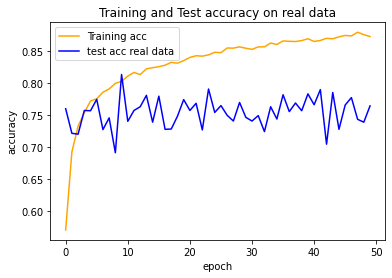

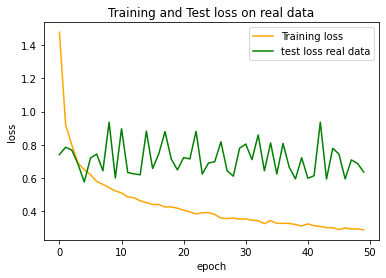

In [ ]:
#plotting training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'orange', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='test acc real data')
plt.title('Training and Test accuracy on real data')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'orange', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='test loss real data')
plt.title('Training and Test loss on real data')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()



In [ ]:
preds=np.round(model.predict(test_data),0)
distributions=['binom','chisq', 'gamma', 'normal','poisson','t-distribution', 'uniform']
classification_matrix= metrics.classification_report(test_labels,preds,target_names=distributions)
print(classification_matrix)





                precision    recall  f1-score   support

         binom       0.52      0.73      0.60       335
         chisq       0.90      0.82      0.86       333
         gamma       1.00      1.00      1.00       333
        normal       0.61      0.82      0.70       333
       poisson       0.61      0.29      0.39       333
t-distribution       0.91      0.68      0.78       333
       uniform       1.00      0.93      0.96       235

     micro avg       0.76      0.74      0.75      2235
     macro avg       0.79      0.75      0.76      2235
  weighted avg       0.78      0.74      0.75      2235
   samples avg       0.74      0.74      0.74      2235



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix


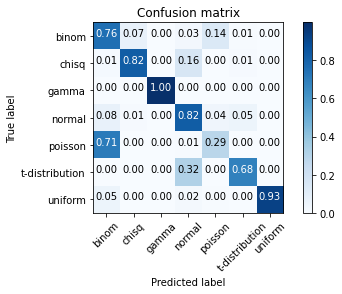

In [ ]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it’s categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
 

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    
    #Add Normalization Option
    ''''prints pretty confusion metric with normalization option'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 


confusion2_matrix= metrics.confusion_matrix(categorical_test_labels,categorical_preds)
plot_confusion_matrix(confusion2_matrix, distributions,normalize=True)



[INFO] loading and preprocessing image…
ID: 0, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 4.38%
ID: 1, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 0.43%
ID: 2, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 0.41%
ID: 3, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 0.37%
ID: 4, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 2.27%
ID: 5, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 91.28%
ID: 6, Label: ['binom', 'chisq', 'gamma', 'normal', 'poisson', 't-distribution', 'uniform'] 0.86%
Final Decision:
.
..
...
ID: 5, Label: t-distribution


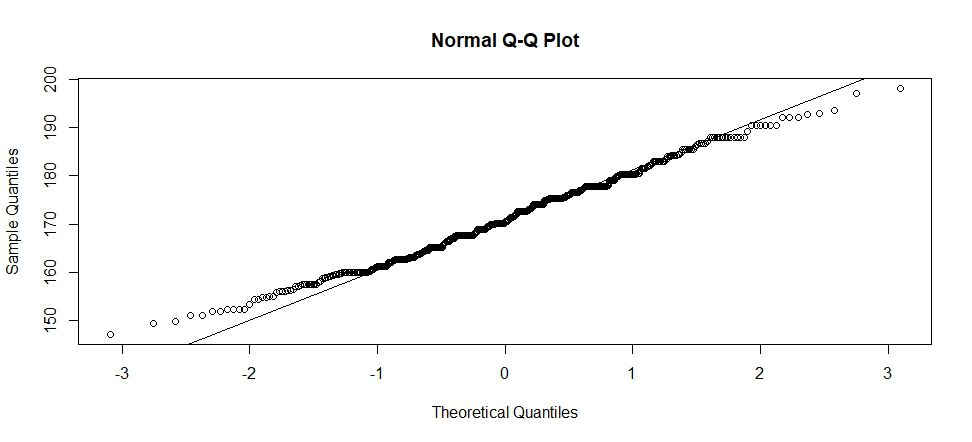

In [ ]:
#testing a simple image

def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    
    return image

def test_single_image(path):
    distributions=['binom','chisq', 'gamma', 'normal','poisson','t-distribution', 'uniform']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,7), distributions, preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, distributions, round(x*100,2) ))
    print("Final Decision:")
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
    return load_img(path)

path = "/content/drive/My Drive/Colab Notebooks/my_data/test500.jpeg"
test_single_image(path)